In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score

#ensembling
from mlxtend.classifier import StackingCVClassifier

In [5]:
matches=pd.read_csv("/content/drive/My Drive/Machine Learning Algorithm/IPL Match Winner Prediction/matches.csv")
matches

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,2019,Mumbai,05/05/19,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,HH Pandya,Wankhede Stadium,Nanda Kishore,O Nandan,S Ravi
752,11412,2019,Chennai,07/05/19,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,AS Yadav,M. A. Chidambaram Stadium,Nigel Llong,Nitin Menon,Ian Gould
753,11413,2019,Visakhapatnam,08/05/19,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,RR Pant,ACA-VDCA Stadium,NaN,NaN,NaN
754,11414,2019,Visakhapatnam,10/05/19,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,F du Plessis,ACA-VDCA Stadium,Sundaram Ravi,Bruce Oxenford,Chettithody Shamshuddin


In [6]:
matches = matches.loc[matches['season'] >= 2015]
matches.head(10)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN
5,6,2017,Hyderabad,2017-04-09,Gujarat Lions,Sunrisers Hyderabad,Sunrisers Hyderabad,field,normal,0,Sunrisers Hyderabad,0,9,Rashid Khan,"Rajiv Gandhi International Stadium, Uppal",A Deshmukh,NJ Llong,NaN
6,7,2017,Mumbai,2017-04-09,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,4,N Rana,Wankhede Stadium,Nitin Menon,CK Nandan,NaN
7,8,2017,Indore,2017-04-10,Royal Challengers Bangalore,Kings XI Punjab,Royal Challengers Bangalore,bat,normal,0,Kings XI Punjab,0,8,AR Patel,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
8,9,2017,Pune,2017-04-11,Delhi Daredevils,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Delhi Daredevils,97,0,SV Samson,Maharashtra Cricket Association Stadium,AY Dandekar,S Ravi,NaN
9,10,2017,Mumbai,2017-04-12,Sunrisers Hyderabad,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,4,JJ Bumrah,Wankhede Stadium,Nitin Menon,CK Nandan,NaN


##Visualization

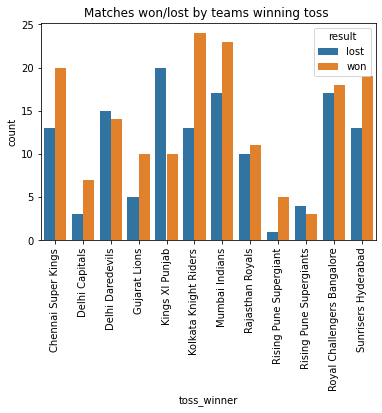

In [7]:
#Toss affecting the win dataframe
toss_win_result = matches.groupby(['toss_winner']).winner.value_counts().reset_index(name="count")
toss_win_result['result']=np.where(toss_win_result.winner==toss_win_result.toss_winner,'won','lost')
toss_win_result_df = toss_win_result.groupby(['toss_winner','result'])['count'].sum().reset_index()
#Visualization
plot = sns.barplot(x="toss_winner", y="count", hue="result", data=toss_win_result_df)
plot.set_title('Matches won/lost by teams winning toss ')
plot.set_xticklabels(toss_win_result_df['toss_winner'].unique(),rotation=90)
plt.show()

Text(0.5, 1.0, 'No of matches won by different teams')

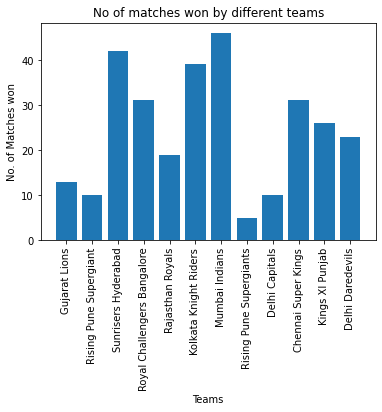

In [8]:
teams = list(set(matches.loc[:,'team1']))
matches_won = [len(matches.loc[matches['winner'] == i]) for i in teams]
plt.bar(np.arange(len(teams)), matches_won)
plt.xticks(np.arange(len(teams)), teams, rotation='vertical')
plt.ylabel('No. of Matches won')
plt.xlabel('Teams')
plt.title('No of matches won by different teams')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


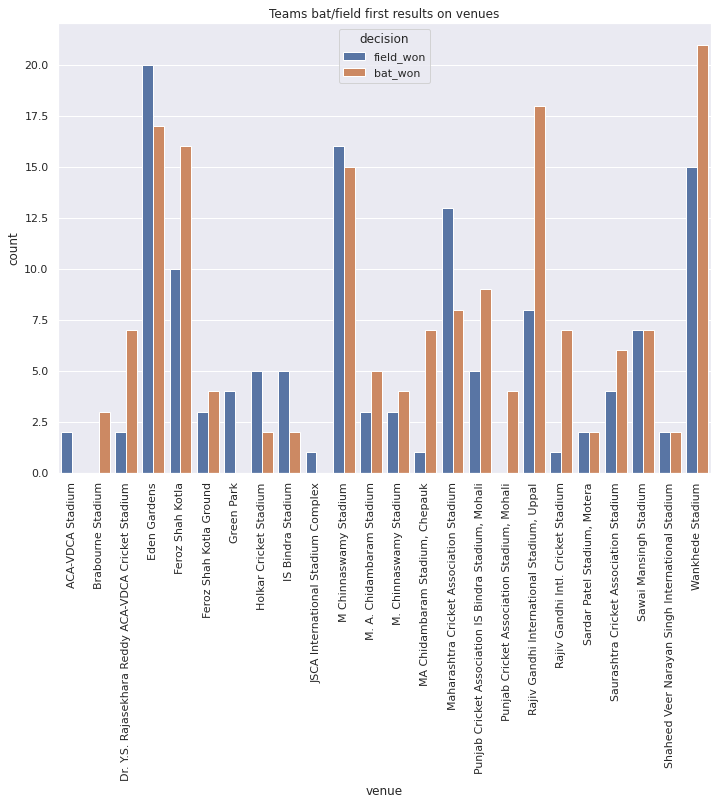

In [9]:
#Winning stats of teams bat/field first by venues 
venue_toss_decision_result=matches[["toss_winner","toss_decision","winner","venue"]]
venue_toss_decision_result["decision"]=np.where((venue_toss_decision_result.toss_winner == venue_toss_decision_result.winner) & (venue_toss_decision_result.toss_decision=="field"),"field_won","bat_won")
venue_result=venue_toss_decision_result.groupby(["venue"]).decision.value_counts().reset_index(name="count")
#Visualization
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.barplot(x="venue", y="count", hue="decision", data=venue_result)
plot.set_title('Teams bat/field first results on venues')
plot.set_xticklabels(venue_result['venue'].unique(),rotation=90)
plt.show()

Text(0.5, 1.0, 'No of matches won by different teams')

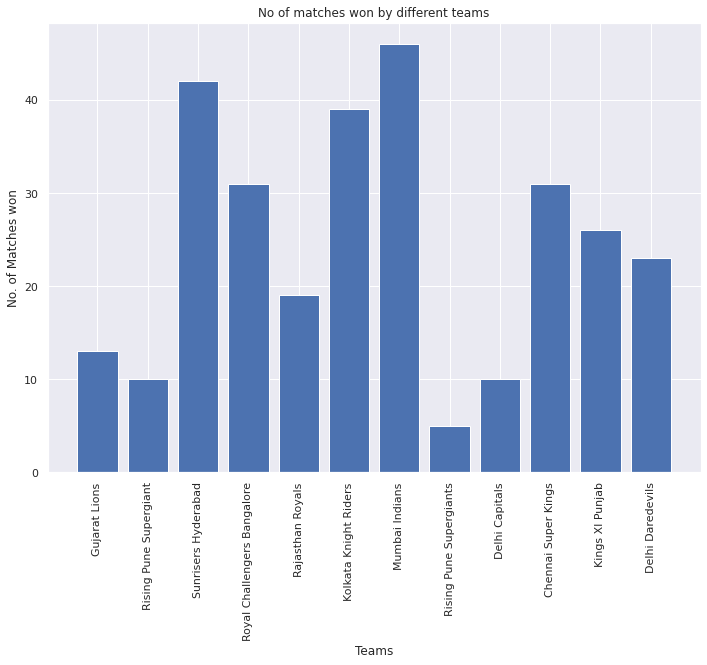

In [10]:
teams = list(set(matches.loc[:,'team1']))
matches_won = [len(matches.loc[matches['winner'] == i]) for i in teams]
plt.bar(np.arange(len(teams)), matches_won)
plt.xticks(np.arange(len(teams)), teams, rotation='vertical')
plt.ylabel('No. of Matches won')
plt.xlabel('Teams')
plt.title('No of matches won by different teams')

##Preprocessing

Null value handling

In [11]:
matches.isnull().sum()

id                   0
season               0
city                 0
date                 0
team1                0
team2                0
toss_winner          0
toss_decision        0
result               0
dl_applied           0
winner               3
win_by_runs          0
win_by_wickets       0
player_of_match      3
venue                0
umpire1              2
umpire2              2
umpire3            179
dtype: int64

In [12]:
#imputing the values in column city based on venue
conditions = [matches["venue"] == "Rajiv Gandhi International Stadium, Uppal",matches["venue"] == "Maharashtra Cricket Association Stadium",
              matches["venue"] == "Saurashtra Cricket Association Stadium", matches["venue"] == "Holkar Cricket Stadium",
              matches["venue"] == "M Chinnaswamy Stadium",matches["venue"] == "Wankhede Stadium",
              matches["venue"] == "Eden Gardens",matches["venue"] == "Feroz Shah Kotla",
              matches["venue"] == "Punjab Cricket Association IS Bindra Stadium, Mohali",matches["venue"] == "Green Park",
              matches["venue"] == "Punjab Cricket Association Stadium, Mohali",matches["venue"] == "Dr DY Patil Sports Academy",
              matches["venue"] == "Sawai Mansingh Stadium", matches["venue"] == "MA Chidambaram Stadium, Chepauk", 
              matches["venue"] == "Newlands", matches["venue"] == "St George's Park" , 
              matches["venue"] == "Kingsmead", matches["venue"] == "SuperSport Park",
              matches["venue"] == "Buffalo Park", matches["venue"] == "New Wanderers Stadium",
              matches["venue"] == "De Beers Diamond Oval", matches["venue"] == "OUTsurance Oval", 
              matches["venue"] == "Brabourne Stadium",matches["venue"] == "Sardar Patel Stadium", 
              matches["venue"] == "Barabati Stadium", matches["venue"] == "Vidarbha Cricket Association Stadium, Jamtha",
              matches["venue"] == "Himachal Pradesh Cricket Association Stadium",matches["venue"] == "Nehru Stadium",
              matches["venue"] == "Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium",matches["venue"] == "Subrata Roy Sahara Stadium",
              matches["venue"] == "Shaheed Veer Narayan Singh International Stadium",matches["venue"] == "JSCA International Stadium Complex",
              matches["venue"] == "Sheikh Zayed Stadium",matches["venue"] == "Sharjah Cricket Stadium",
              matches["venue"] == "Dubai International Cricket Stadium",matches["venue"] == "M. A. Chidambaram Stadium",
              matches["venue"] == "Feroz Shah Kotla Ground",matches["venue"] == "M. Chinnaswamy Stadium",
              matches["venue"] == "Rajiv Gandhi Intl. Cricket Stadium" ,matches["venue"] == "IS Bindra Stadium",matches["venue"] == "ACA-VDCA Stadium"]
values = ['Hyderabad', 'Mumbai', 'Rajkot',"Indore","Bengaluru","Mumbai","Kolkata","Delhi","Mohali","Kanpur","Mohali","Pune","Jaipur","Chennai","Cape Town","Port Elizabeth","Durban",
          "Centurion",'Eastern Cape','Johannesburg','Northern Cape','Bloemfontein','Mumbai','Ahmedabad','Cuttack','Jamtha','Dharamshala','Chennai','Visakhapatnam','Pune','Raipur','Ranchi',
          'Abu Dhabi','Sharjah','Dubai','Chennai','Delhi','Bengaluru','Hyderabad','Mohali','Visakhapatnam']
matches['city'] = np.where(matches['city'].isnull(),
                              np.select(conditions, values),
                              matches['city'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
matches[pd.isnull(matches['winner'])]
#find all NaN values in winner column, so that we update this as draw

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
545,546,2015,Bangalore,2015-04-29,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,no result,0,NaN,0,0,NaN,M Chinnaswamy Stadium,JD Cloete,PG Pathak,NaN
570,571,2015,Bangalore,2015-05-17,Delhi Daredevils,Royal Challengers Bangalore,Royal Challengers Bangalore,field,no result,0,NaN,0,0,NaN,M Chinnaswamy Stadium,HDPK Dharmasena,K Srinivasan,NaN
744,11340,2019,Bengaluru,30/04/19,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,no result,0,NaN,0,0,NaN,M. Chinnaswamy Stadium,Nigel Llong,Ulhas Gandhe,Anil Chaudhary


In [14]:
#find all NaN values in winner column, so that we update this as draw
matches['winner'].fillna('Draw', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [15]:
matches.isnull().sum()

id                   0
season               0
city                 0
date                 0
team1                0
team2                0
toss_winner          0
toss_decision        0
result               0
dl_applied           0
winner               0
win_by_runs          0
win_by_wickets       0
player_of_match      3
venue                0
umpire1              2
umpire2              2
umpire3            179
dtype: int64

Attribute Selection

In [16]:
# all teams played in between 2008-2019
matches['team1'].unique()

array(['Sunrisers Hyderabad', 'Mumbai Indians', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals',
       'Rising Pune Supergiants', 'Delhi Capitals'], dtype=object)

In [17]:
#Replacing the Rising Pune Supergiant with Rising Pune Supergiants
matches["team2"]=matches["team2"].replace("Rising Pune Supergiant","Rising Pune Supergiants")
matches["team1"]=matches["team1"].replace("Rising Pune Supergiant","Rising Pune Supergiants")
matches["winner"]=matches["winner"].replace("Rising Pune Supergiant","Rising Pune Supergiants")
matches["toss_winner"]=matches["toss_winner"].replace("Rising Pune Supergiant","Rising Pune Supergiants")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [18]:
#encoder
encoder= LabelEncoder()
matches["team1"]=encoder.fit_transform(matches["team1"])
matches["team2"]=encoder.fit_transform(matches["team2"])
matches["winner"]=encoder.fit_transform(matches["winner"])
matches["toss_winner"]=encoder.fit_transform(matches["toss_winner"])
matches["venue"]=encoder.fit_transform(matches["venue"])
matches["city"]=encoder.fit_transform(matches["city"])
matches["toss_decision"]=encoder.fit_transform(matches["toss_decision"])
matches


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,6,2017-04-05,10,9,9,1,normal,0,11,35,0,Yuvraj Singh,17,AY Dandekar,NJ Llong,NaN
1,2,2017,13,2017-04-06,6,8,8,1,normal,0,9,0,7,SPD Smith,14,A Nand Kishore,S Ravi,NaN
2,3,2017,15,2017-04-07,3,5,5,1,normal,0,6,0,10,CA Lynn,20,Nitin Menon,CK Nandan,NaN
3,4,2017,7,2017-04-08,8,4,4,1,normal,0,5,0,6,GJ Maxwell,7,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,1,2017-04-08,9,2,9,0,normal,0,10,15,0,KM Jadhav,10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,2019,12,05/05/19,5,6,6,1,normal,0,7,0,9,HH Pandya,23,Nanda Kishore,O Nandan,S Ravi
752,11412,2019,4,07/05/19,0,6,0,0,normal,0,7,0,6,AS Yadav,11,Nigel Llong,Nitin Menon,Ian Gould
753,11413,2019,17,08/05/19,10,1,1,1,normal,0,1,0,2,RR Pant,0,NaN,NaN,NaN
754,11414,2019,17,10/05/19,1,0,0,1,normal,0,0,0,6,F du Plessis,0,Sundaram Ravi,Bruce Oxenford,Chettithody Shamshuddin


In [19]:
#outcome variable as a probability of team1 winning
matches.loc[matches["winner"]==matches["team1"],"team1_win"]=1
matches.loc[matches["winner"]!=matches["team1"],"team1_win"]=0

matches.loc[matches["toss_winner"]==matches["team1"],"team1_toss_win"]=1
matches.loc[matches["toss_winner"]!=matches["team1"],"team1_toss_win"]=0

matches["team1_bat"]=0
matches.loc[(matches["team1_toss_win"]==1) & (matches["toss_decision"]=="bat"),"team1_bat"]=1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [20]:
# all feasible columns
matches = matches[["team1","team2","team1_toss_win","team1_bat","team1_win","venue"]]
matches

,team1,team2,team1_toss_win,team1_bat,team1_win,venue
0,10,9,0.0,0,0.0,17
1,6,8,0.0,0,0.0,14
2,3,5,0.0,0,0.0,20
3,8,4,0.0,0,0.0,7
4,9,2,1.0,0,0.0,10
...,...,...,...,...,...,...
751,5,6,0.0,0,0.0,23
752,0,6,1.0,0,0.0,11
753,10,1,0.0,0,0.0,0
754,1,0,0.0,0,0.0,0


In [21]:
#dropping higly correlated features
correlated_features = set()
correlation_matrix = matches.drop('team1_win', axis=1).corr()
correlation_matrix

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

matches.drop(columns=correlated_features)

,team1,team2,team1_toss_win,team1_bat,team1_win,venue
0,10,9,0.0,0,0.0,17
1,6,8,0.0,0,0.0,14
2,3,5,0.0,0,0.0,20
3,8,4,0.0,0,0.0,7
4,9,2,1.0,0,0.0,10
...,...,...,...,...,...,...
751,5,6,0.0,0,0.0,23
752,0,6,1.0,0,0.0,11
753,10,1,0.0,0,0.0,0
754,1,0,0.0,0,0.0,0


In [22]:
matches.isnull().sum()

team1             0
team2             0
team1_toss_win    0
team1_bat         0
team1_win         0
venue             0
dtype: int64

##Train-Test Split

In [23]:
X = matches.drop('team1_win', axis=1)
#X = X.drop('city', axis=1)
#X = X.drop('toss_decision', axis=1)
target = matches['team1_win']
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.1, random_state=0)

In [24]:
'''
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
'''

'\nsc = StandardScaler()\nX_train = sc.fit_transform(X_train)\nX_test = sc.transform(X_test)\n'

In [25]:
len(y_train)

268

##Model Selection

In [26]:
# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier(n_estimators=100),
         "Linear Support Vector" : SVC(kernel='rbf', C=1, gamma=1),
         "naive_bayes": GaussianNB(),
         "Decision tree": DecisionTreeClassifier(),
          "XGBoost" : XGBClassifier()
            }

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [27]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'Decision tree': 0.8666666666666667,
 'KNN': 0.9666666666666667,
 'Linear Support Vector': 0.9,
 'Logistic Regression': 0.9,
 'Random Forest': 0.9,
 'XGBoost': 0.9333333333333333,
 'naive_bayes': 0.9333333333333333}

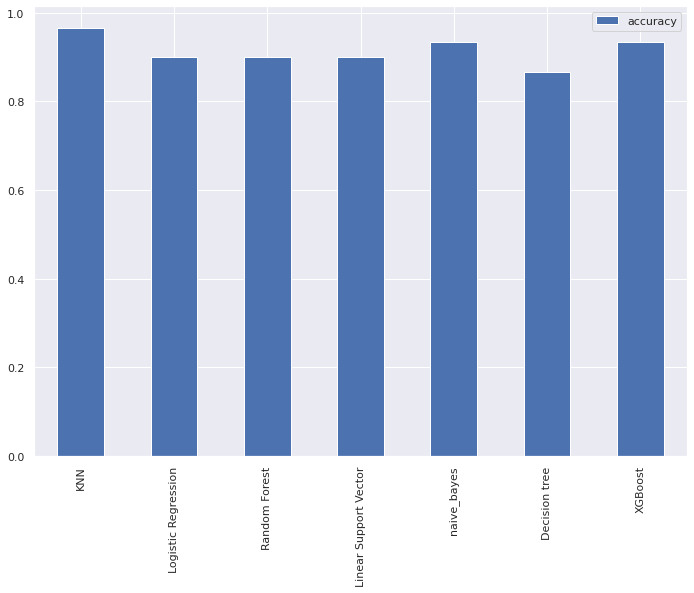

In [28]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

##Neural Network Architecture

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [30]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [31]:
X_test , y_train = np.array(X_test), np.array(y_train)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


LSTM

In [32]:
regressor = Sequential()
regressor.add(LSTM(units = 50, input_shape = (X_train.shape[1], 1)))
regressor.add(Dense(units = 15))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])

history = regressor.fit(X_train, y_train,validation_data=(X_test, y_test), epochs = 10, batch_size = 16)

Epoch 1/10
17/17 [==============================] - 0s 28ms/step - loss: 0.1398 - accuracy: 0.0224 - val_loss: 0.0177 - val_accuracy: 0.0000e+00
Epoch 2/10
17/17 [==============================] - 0s 4ms/step - loss: 0.1121 - accuracy: 0.0261 - val_loss: 0.0176 - val_accuracy: 0.0000e+00
Epoch 3/10
17/17 [==============================] - 0s 4ms/step - loss: 0.1091 - accuracy: 0.0000e+00 - val_loss: 0.0146 - val_accuracy: 0.0000e+00
Epoch 4/10
17/17 [==============================] - 0s 3ms/step - loss: 0.1077 - accuracy: 0.0000e+00 - val_loss: 0.0154 - val_accuracy: 0.0000e+00
Epoch 5/10
17/17 [==============================] - 0s 4ms/step - loss: 0.1069 - accuracy: 0.0000e+00 - val_loss: 0.0130 - val_accuracy: 0.0000e+00
Epoch 6/10
17/17 [==============================] - 0s 4ms/step - loss: 0.1056 - accuracy: 0.0000e+00 - val_loss: 0.0152 - val_accuracy: 0.0000e+00
Epoch 7/10
17/17 [==============================] - 0s 4ms/step - loss: 0.1044 - accuracy: 0.0000e+00 - val_loss: 0.014

In [33]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

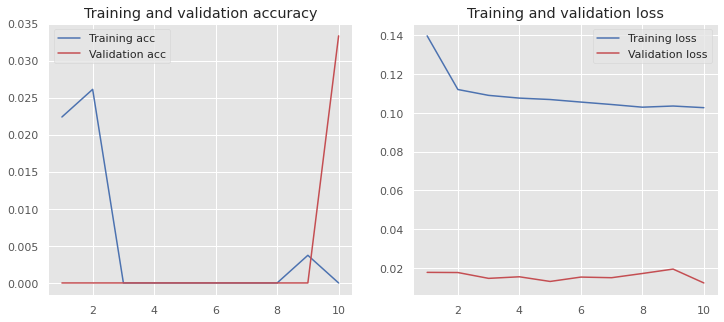

In [34]:
plot_history(history)

RNN

In [35]:
from keras import layers

regressor = Sequential()
regressor.add(layers.SimpleRNN(units = 50, input_shape = (X_train.shape[1], 1)))
regressor.add(Dense(units = 15))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])

history = regressor.fit(X_train, y_train,validation_data=(X_test, y_test), epochs = 10, batch_size = 16)

Epoch 1/10
17/17 [==============================] - 0s 12ms/step - loss: 0.8510 - accuracy: 0.0000e+00 - val_loss: 0.2842 - val_accuracy: 0.0000e+00
Epoch 2/10
17/17 [==============================] - 0s 3ms/step - loss: 0.2635 - accuracy: 0.0000e+00 - val_loss: 0.1046 - val_accuracy: 0.0000e+00
Epoch 3/10
17/17 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.0187 - val_loss: 0.0590 - val_accuracy: 0.1000
Epoch 4/10
17/17 [==============================] - 0s 3ms/step - loss: 0.1161 - accuracy: 0.0634 - val_loss: 0.0426 - val_accuracy: 0.2333
Epoch 5/10
17/17 [==============================] - 0s 3ms/step - loss: 0.1065 - accuracy: 0.1269 - val_loss: 0.0374 - val_accuracy: 0.1667
Epoch 6/10
17/17 [==============================] - 0s 3ms/step - loss: 0.1042 - accuracy: 0.1231 - val_loss: 0.0287 - val_accuracy: 0.2333
Epoch 7/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0962 - accuracy: 0.1231 - val_loss: 0.0320 - val_accuracy: 0.2667
Epo

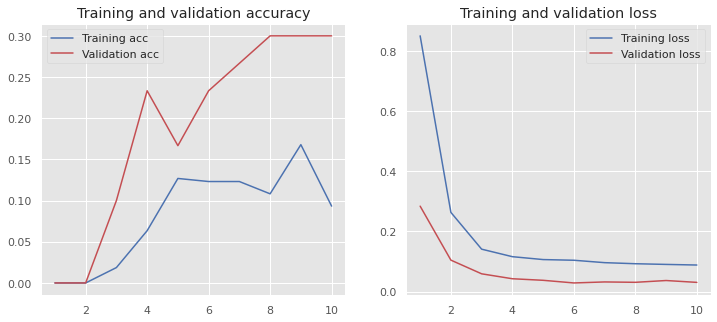

In [36]:
plot_history(history)

Random Neural Architecture

In [37]:
import keras
# Creating model
model = Sequential()
model.add(Dense(100, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(75, activation="relu"))
model.add(Dense(75, activation="relu"))
model.add(Dense(15))
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_squared_error', metrics=["accuracy"])

history = regressor.fit(X_train, y_train,validation_data=(X_test, y_test), epochs = 10, batch_size = 16)

Epoch 1/10
17/17 [==============================] - 0s 5ms/step - loss: 0.0866 - accuracy: 0.0858 - val_loss: 0.0332 - val_accuracy: 0.2667
Epoch 2/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0852 - accuracy: 0.0821 - val_loss: 0.0370 - val_accuracy: 0.2333
Epoch 3/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0868 - accuracy: 0.0410 - val_loss: 0.0331 - val_accuracy: 0.2667
Epoch 4/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0822 - accuracy: 0.0746 - val_loss: 0.0390 - val_accuracy: 0.0333
Epoch 5/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0810 - accuracy: 0.0560 - val_loss: 0.0364 - val_accuracy: 0.3333
Epoch 6/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0798 - accuracy: 0.0896 - val_loss: 0.0420 - val_accuracy: 0.0333
Epoch 7/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0774 - accuracy: 0.0634 - val_loss: 0.0416 - val_accuracy: 0.1000
Epoch 8/10
17/17 [==

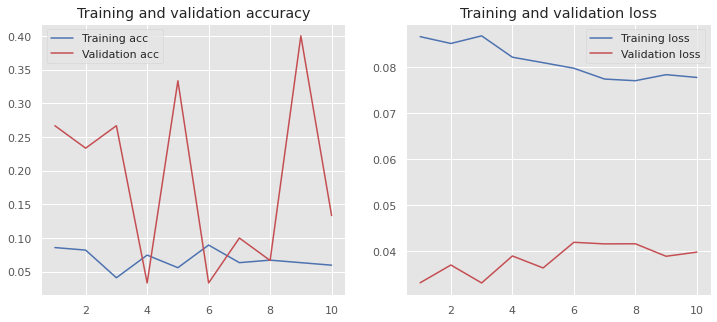

In [38]:
plot_history(history)